# Avocado Price Prediction

In this notebook, we will:
- Load and explore the avocado pricing dataset.
- Perform data preprocessing and feature engineering.
- Analyze correlations between features and avocado prices.
- Develop machine learning models (Linear Regression and Random Forest) to predict avocado prices.
- Forecast future avocado prices for the upcoming months.
- Discuss additional improvements and external factors (e.g., weather, economic indicators) that could further boost the model’s performance.


In [3]:
# %% [code]
# Install seaborn if not already installed

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For reproducibility
RANDOM_STATE = 42


## 1. Data Loading and Exploration

We begin by loading the CSV file and inspecting the data structure, summary statistics, and checking for missing values.


In [4]:
# %% [code]
# Load the avocado CSV file
csv_path = "avocado.csv"  # Adjust path if needed
df = pd.read_csv(csv_path)

# Show the first few rows
print("First 5 rows:")
display(df.head())

# Get dataset info and check missing values
print("Dataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())


First 5 rows:


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB

Missing Values:
Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
47

## 2. Data Preprocessing and Feature Engineering

We need to convert the date string to datetime format, extract time-based features (month, week, year), encode categorical variables (e.g., type, region), and drop any redundant columns.


In [5]:
# %% [code]
# Drop or rename the unnecessary index column
if "Unnamed: 0" in df.columns:
    df.rename(columns={"Unnamed: 0": "Id"}, inplace=True)
    
# Convert 'Date' column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Extract time-based features
df["month"] = df["Date"].dt.month
df["week"] = df["Date"].dt.isocalendar().week
df["year"] = df["Date"].dt.year

# Encode the 'type' column: conventional -> 0, organic -> 1
df["type"] = df["type"].map({"conventional": 0, "organic": 1})

# One-hot encode the 'region' column
df = pd.get_dummies(df, columns=["region"], drop_first=True)

# Check the transformed data
print("Data after preprocessing:")
df.info()


Data after preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Id                          18249 non-null  int64         
 1   Date                        18249 non-null  datetime64[ns]
 2   AveragePrice                18249 non-null  float64       
 3   Total Volume                18249 non-null  float64       
 4   4046                        18249 non-null  float64       
 5   4225                        18249 non-null  float64       
 6   4770                        18249 non-null  float64       
 7   Total Bags                  18249 non-null  float64       
 8   Small Bags                  18249 non-null  float64       
 9   Large Bags                  18249 non-null  float64       
 10  XLarge Bags                 18249 non-null  float64       
 11  type                        

## 3. Exploratory Data Analysis (EDA)

Let's visualize the data. We'll look at the avocado price trend over time and check the correlation between features and the target variable (`AveragePrice`).


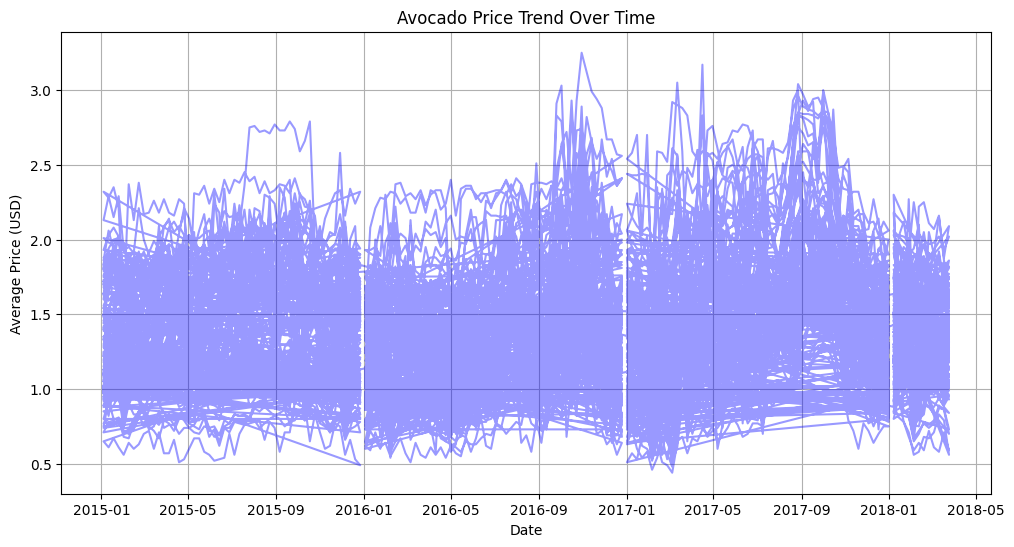

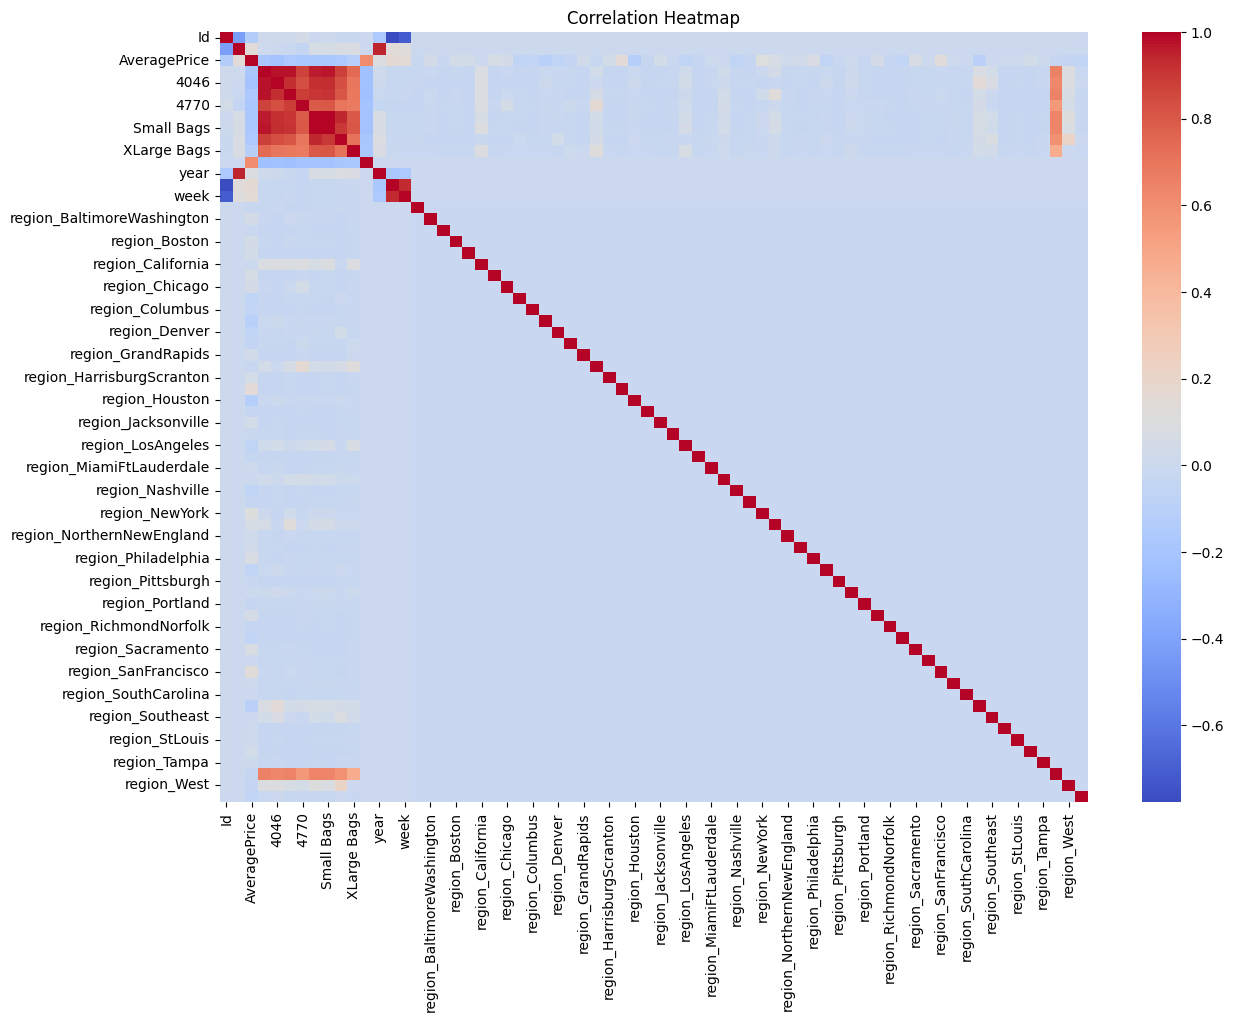

Correlation of features with AveragePrice:
AveragePrice    1.000000
type            0.615845
month           0.162409
week            0.146383
Date            0.145514
                  ...   
Small Bags     -0.174730
Total Bags     -0.177088
4770           -0.179446
Total Volume   -0.192752
4046           -0.208317
Name: AveragePrice, Length: 68, dtype: float64


In [6]:
# %% [code]
# Plot the trend of AveragePrice over time
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["AveragePrice"], color="blue", alpha=0.4)
plt.xlabel("Date")
plt.ylabel("Average Price (USD)")
plt.title("Avocado Price Trend Over Time")
plt.grid(True)
plt.show()

# Compute the correlation matrix
corr_matrix = df.corr()

# Plot a heatmap of correlations (focusing on numerical features)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Optional: Check correlations with AveragePrice specifically
price_corr = corr_matrix["AveragePrice"].sort_values(ascending=False)
print("Correlation of features with AveragePrice:")
print(price_corr)


## 4. Model Development

### 4.1 Feature Selection and Splitting the Data

We separate the features from the target variable. In this example, we remove non-numeric or non-informative columns like `Date` and `Id`.


In [7]:
# %% [code]
# Define features (X) and target variable (y)
# Dropping Date and AveragePrice from X; you can drop Id if not informative.
X = df.drop(columns=["Date", "AveragePrice", "Id"])
y = df["AveragePrice"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


### 4.2 Baseline Model: Linear Regression

We first build a baseline model using Linear Regression and evaluate its performance.


In [8]:
# %% [code]
# Initialize and train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_lr = lin_reg.predict(X_test)
lr_r2 = lin_reg.score(X_test, y_test)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression Performance:")
print("R² Score:", lr_r2)
print("MAE:", lr_mae)
print("RMSE:", lr_rmse)


Linear Regression Performance:
R² Score: 0.5864527163641089
MAE: 0.19486744168792128
RMSE: 0.2577678470451691


### 4.3 Advanced Model: Random Forest Regressor

Since avocado pricing might be influenced by non-linear factors, we also try a Random Forest model.


In [9]:
# %% [code]
# Initialize and train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Performance:")
print("R² Score:", rf_r2)
print("MAE:", rf_mae)
print("RMSE:", rf_rmse)


Random Forest Performance:
R² Score: 0.9113016790735687
MAE: 0.08461580821917809
RMSE: 0.11937787866714875


## 5. Forecasting Future Avocado Prices

We'll generate future dates and predict avocado prices for the upcoming months using our model. Here, we fill in missing feature values with the mean from our training data. In a real-world scenario, you could integrate external factors (e.g., weather data, economic indicators) to improve these predictions.


In [10]:
# %% [code]
# Define future dates (end-of-month) starting from a given date
future_dates = pd.date_range(start="2025-03-01", periods=6, freq="M")  # Use frequency "M" for month-end

# Create a new DataFrame for future predictions
future_df = pd.DataFrame({"Date": future_dates})
future_df["month"] = future_df["Date"].dt.month
future_df["week"] = future_df["Date"].dt.isocalendar().week
future_df["year"] = future_df["Date"].dt.year

# For all other features (from X_train), fill with the mean value from the training set.
# In practice, you could incorporate predicted external factors or seasonal adjustments.
for col in X_train.columns:
    if col not in future_df.columns:
        future_df[col] = X_train[col].mean()

# Ensure the feature order matches the training set
future_X = future_df[X_train.columns]

# Choose the best performing model for forecasting; here, we use the Random Forest model.
future_df["PredictedPrice"] = rf_model.predict(future_X)

print("Future Avocado Price Predictions:")
display(future_df[["Date", "PredictedPrice"]])


Future Avocado Price Predictions:


C:\Users\ghara\AppData\Local\Temp\ipykernel_13284\79591448.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start="2025-03-01", periods=6, freq="M")  # Use frequency "M" for month-end


,Date,PredictedPrice
0,2025-03-31,1.0670
1,2025-04-30,1.5044
2,2025-05-31,1.5295
3,2025-06-30,1.4769
4,2025-07-31,1.4318
5,2025-08-31,1.6873


## 6. Conclusion and Future Improvements

### Summary:
- We loaded and preprocessed the avocado dataset by converting date columns, extracting time features, and encoding categorical variables.
- Exploratory analysis (line plots and correlation heatmaps) helped us understand the trends and relationships in the data.
- Two models were developed: a baseline Linear Regression and an advanced Random Forest Regressor.
- The Random Forest model (which typically handles non-linear relationships better) was used to forecast future avocado prices.

### Future Improvements:
- **Feature Engineering:**  
  - Incorporate lag features (e.g., previous month's prices) and rolling averages to capture historical trends.
  - Integrate external data such as weather patterns, economic indicators, or consumer sentiment.
- **Model Tuning:**  
  - Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning.
  - Explore other advanced models (e.g., Gradient Boosting, XGBoost, or deep learning methods).
- **Time Series Analysis:**  
  - Consider using time series forecasting methods (ARIMA, Prophet) to capture seasonality and trends more directly.
- **Error Handling and Logging:**  
  - Enhance the notebook by adding try/except blocks and logging to manage and track errors or model performance over time.

This notebook provides a strong foundation for avocado price prediction and can be further refined with additional data and advanced modeling techniques.
